## Hierarchical convolutional sparse coding

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from scipy.io import loadmat
from tensorboardX import SummaryWriter
import torch
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from SDPC_PCB.Network import LayerPC, Network
from SDPC_PCB.Coding import ML_Lasso,ML_FISTA
from SDPC_PCB.DataTools import gaussian_kernel
from SDPC_PCB.Monitor import Monitor
from SDPC_PCB.Optimizers import mySGD, myAdam
from SDPC_PCB.DataTools import norm
from sparsecoding.data.transforms.patch import patchify

In [1]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.axis('off')
    return plt


def reconstruction(Net, gamma):
    reco = [None] * (Net.nb_layers)
    for i in range(Net.nb_layers-1, -1, -1):
        reco[i] = gamma[i]
        for j in range(i, -1, -1):
            reco[i] = Net.layers[j].backward(reco[i])
    return reco

class FieldDataset(Dataset):
    """Dataset used in Olshausen & Field (1996).

    Paper:
        https://courses.cs.washington.edu/courses/cse528/11sp/Olshausen-nature-paper.pdf
        Emergence of simple-cell receptive field properties
        by learning a sparse code for natural images.

    Parameters
    ----------
    root : str
        Location to download the dataset to.
    patch_size : int
        Side length of patches for sparse dictionary learning.
    """

    B = 10
    C = 1
    H = 512
    W = 512

    def __init__(
        self,
        root: str,
        patch_size: int = 8,
    ):
        self.P = patch_size

        root = os.path.expanduser(root)
        os.system(f"mkdir -p {root}")
        if not os.path.exists(f"{root}/field.mat"):
            os.system("wget https://rctn.org/bruno/sparsenet/IMAGES.mat")
            os.system(f"mv IMAGES.mat {root}/field.mat")

        self.images = torch.tensor(
            loadmat(f"{root}/field.mat")["IMAGES"])  # [H, W, B]
        assert self.images.shape == (self.H, self.W, self.B)

        self.images = torch.permute(self.images, (2, 0, 1))  # [B, H, W]
        # make 3 channel
        # self.images = torch.cat([self.images, self.images, self.images], dim=1)  # convert to 3 channel
        self.images = torch.reshape(
            self.images, (self.B, self.C, self.H, self.W))  # [B, C, H, W]

        self.patches = patchify(patch_size, self.images)  # [B, N, C, P, P]
        self.patches = torch.reshape(
            self.patches, (-1, self.C, self.P, self.P))  # [B*N, C, P, P]
        self.patches = self.patches.float()

    def __len__(self):
        return self.patches.shape[0]

    def __getitem__(self, idx):
        return self.patches[idx]


NameError: name 'Dataset' is not defined

### load STL model

In [5]:
#model_name = 'STL_20tr_l=[0.4,1.6]_b=1_learnv_v=6_[64,128]_sig=30_sz=8_stride=2.pkl'
import SDPC_PCB
import sys
import io
model_name = 'STL_[0.4,1.6]_b=1.pkl'

model_type = model_name[0:8]
name = model_name
print(name)
where = 'Savings/STL/'
path = where + name

# load pickled model and accomodate old structure

# https://stackoverflow.com/questions/57081727/load-pickle-file-obtained-from-gpu-to-cpu


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)


# https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
sys.modules["SDPC"] = SDPC_PCB

with open(path, 'rb') as file:
    out = CPU_Unpickler(file).load()

Net = out['Net']
Pursuit = out['Pursuit']
Loss = out['Loss']


STL_[0.4,1.6]_b=1.pkl


### try training STL model on bruno images

In [3]:
# Load Bruno images, each batch is [batch_size, 1, 96, 96]
dataset = FieldDataset(".", patch_size=96)
database = DataLoader(dataset, batch_size=20, shuffle=True, drop_last=True)
input_size = list(next(iter(database)).shape)

## Setting parameters
dict_sizes = [(64,1,8,8), (128,64,8,8)] # [Layer 1, Layer 2]
l_r = [1e-4,5e-3]#### dictionaries learning rate [Layer1, Layer2] 
l_rv = [1e-3,1e-3]#### normalizer learning rate [Layer1, Layer2]
l = [0.4,1.6]#### Sparsity parameters [Layer1, Layer2]
b=1 #### Feedback strength parameter. b=0 --> Hila, b=1 --> 2L-SPC
v_i=[10,10] #### Initial normalizer value [Layer1, Layer2]
nb_epoch = 2 #### number of training epochs
Use_tb = True #### Use to activate tensorboard monitoring
save = True #### Use to run the entire simulation : TAKE HOURS. Use False to load previous simulation

## Gaussian masks for the dictionaries
mask_g = [gaussian_kernel(dict_sizes[0], sigma=30), gaussian_kernel(dict_sizes[1], sigma=30)]  # not sure why do this

/Users/galen/Synology/research/rctn/sparsecoding/sparsecoding/data/transforms/patch.py:100: UserWarning: Image size ((512, 512)) not evenly divisible by `patch_size` (96),parts on the bottom and/or right will be cropped.
  warnings.warn(


In [8]:
## Definition of the layers, network and sparse coding algorithm
layer = [LayerPC(dict_sizes[0], stride=2, b=b, v=v_i[0], v_size=64 ,out_pad=0),
        LayerPC(dict_sizes[1], stride=1, b=b, v=v_i[1], v_size=128 ,out_pad=0)]

Net = Network(layer, input_size=input_size)
Loss = ML_Lasso(Net, [l[0],l[1]])
# Pursuit = ML_FISTA(Net, Loss, max_iter=1000, th=1e-4, mode='eigen')
Pursuit = ML_FISTA(Net, Loss, max_iter=10, th=1e-4, mode='eigen')

## Optimizer initialization
opt_dico = [None] * (Net.nb_layers + 1)
for i in range(0, Net.nb_layers):
    opt_dico[i] = mySGD([{'params': Net.layers[i].dico}], lr=l_r[i], momentum=0.9, normalize=True)

opt_v = [myAdam([{'params': Net.layers[i].v}], lr=l_rv[i], normalize=False) \
    for i in range(Net.nb_layers)]

L = [None] * (Net.nb_layers)
L_v = [None] * (Net.nb_layers)
reco = [None] * (Net.nb_layers)

model_name = 'NAT_[{0},{1}]_b={2}'.format(l[0],l[1],b)
path = 'Savings/STL/' + model_name +'.pkl'
if Use_tb : 
    nrows = [8,8,8,8,8,8,8]
    writer = SummaryWriter('Savings/Log/' + model_name)
    M = Monitor(Net, writer, n_row=nrows)

k=0

l2_loss = torch.zeros(2,nb_epoch*len(database))
l1_loss = torch.zeros(2,nb_epoch*len(database))
if save == True : 
    for e in range(nb_epoch):
        for idx_batch, data in enumerate(database):
            print(idx_batch)
            if idx_batch == 5:  # need to somehow limit the number of times databse can be enumerated
                break

            # batch = data[0].cuda()
            batch = data
            gamma, it, Loss_G, delta = Pursuit.coding(batch)

            for i in range(Net.nb_layers):
                Net.layers[i].dico.requires_grad = True
                L[i] = Loss.F(batch, gamma, i, do_feedback=False).div(batch.size()[0])  ## Unsupervised
                L[i].backward()
                Net.layers[i].dico.requires_grad = False
                opt_dico[i].step()
                opt_dico[i].zero_grad()

                ##Mask
                Net.layers[i].dico*=mask_g[i]
                Net.layers[i].dico/=norm(Net.layers[i].dico)
                
                l2_loss[i,k]= L[i].detach() 
                l1_loss[i,k] =  gamma[i].detach().sum().div(gamma[i].size(0))
                

            for i in range(Net.nb_layers):
                Net.layers[i].v.requires_grad = True  # turn_on(i)
                L_v[i] = Loss.F_v(batch, gamma, i).div(batch.size()[0])
                L_v[i].backward()
                Net.layers[i].v.requires_grad = False  # turn_off(i)
                opt_v[i].step()  
                opt_v[i].zero_grad()
                
            if Use_tb:
                if (k%10) == 0:
                    writer.add_scalar('FISTA_iterations', it, k)
                    M.MonitorGamma(gamma, k, option=['NNZ', '%', 'Sum', 'V'])
                    M.MonitorList(L, 'Loss_Dico', k)
                    M.MonitorList(L_v, 'Loss_v', k)
                    M.MonitorDicoBP(k)
                    M.ComputeHisto(gamma)

                if (k%100) == 0:
                    reco = [None] * (Net.nb_layers)
                    for i in range(Net.nb_layers-1,-1,-1):
                        reco[i] = gamma[i]
                        for j in range(i, -1, -1):
                            reco[i] = Net.layers[j].backward(reco[i])
                        reco_image = make_grid(reco[i],normalize=True,pad_value=1)
                        writer.add_image('Reco/L{0}'.format(i),reco_image,k)

            k += 1

    output_exp = {'Net': Net,
            'Loss': Loss,
            'Pursuit': Pursuit,
            'l2_loss': l2_loss,
            'l1_loss': l1_loss    
                 }
    path = 'Savings/NAT/' + model_name +'.pkl'
    with open(path, 'wb') as file:
        pickle.dump(output_exp, file, pickle.HIGHEST_PROTOCOL)
    
else :        
    print("loading pickle")
    with open(path, 'rb') as file:
        output_exp = pickle.load(file)


NETWORK STRUCTURE : 
 Input : [20, 1, 96, 96]
 Layer 1 : [20, 64, 45, 45]
 Layer 2 : [20, 128, 38, 38]
0


100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


KeyboardInterrupt: 

In [76]:
path = 'Savings/STL/' + model_name + "1ch" + '.pkl'
with open(path, 'wb') as file:
    pickle.dump(output_exp, file, pickle.HIGHEST_PROTOCOL)

PicklingError: Can't pickle <class 'SDPC_PCB.Coding.ML_Lasso'>: it's not the same object as SDPC_PCB.Coding.ML_Lasso

In [72]:
%%time

Pursuit.max_iter = 10

# nb_image = 20*20
nb_image = 20
# all_batch = torch.zeros(nb_image,3,96,96).cuda()
# save_gamma_0 = torch.zeros(nb_image,64,45,45).cuda()
# save_gamma_1 = torch.zeros(nb_image,128,38,38).cuda()
all_batch = torch.zeros(nb_image, 3, 96, 96)
save_gamma_0 = torch.zeros(nb_image, 64, 45, 45)  # do we have to change this?
save_gamma_1 = torch.zeros(nb_image, 128, 38, 38)
k = 0

all_batch[k:k+data.size(0), :, :, :] = data
gamma, it, Loss_G, delta = Pursuit.coding(data)
print("done coding batch")

save_gamma_0 = gamma[0][:, :, :, :]
save_gamma_1 = gamma[1][:, :, :, :]


100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


before while
done coding batch
CPU times: user 31.2 s, sys: 504 ms, total: 31.7 s
Wall time: 31.8 s


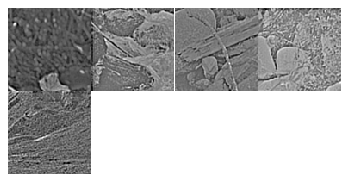

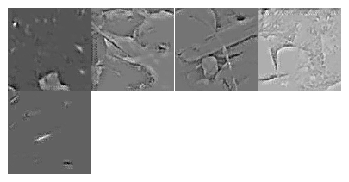

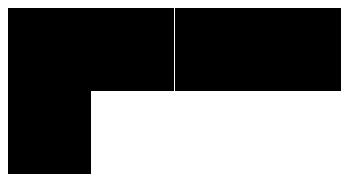

In [73]:
selected_img = [0,1,2,3,4]
gamma_n = [save_gamma_0[selected_img,:,:,:],save_gamma_1[selected_img,:,:,:]]
reco = reconstruction(Net,gamma_n)

save_fig = False

## Display input_data
grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':4, 'scale_each':True}
img2 = show(make_grid(all_batch[selected_img,:,:,:].cpu(),**grid_param))
img2.show()
if save_fig :
    save_image(make_grid(reco[0][:,:,:,:].cpu(), **grid_param), path_saving + '/Fig2/Fig2a.png')

    
## Display fist layer reconstruction
grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':4, 'scale_each':True}
img2 = show(make_grid(reco[0][:,:,:,:].cpu(),**grid_param))
img2.show()
if save_fig :
    save_image(make_grid(reco[0][:,:,:,:].cpu(), **grid_param), path_saving + '/Fig2/Fig2c.png')

## Display second layer reconstruction
grid_param = {'padding':1, 'normalize':True, 'pad_value':1,  'nrow':4, 'scale_each':True}
img2 = show(make_grid(reco[1][:,:,:,:].cpu(),**grid_param))
img2.show()
if save_fig :
    save_image(make_grid(reco[1][:,:,:,:].cpu(), **grid_param), path_saving +'/Fig2/Fig2e.png')

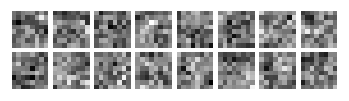

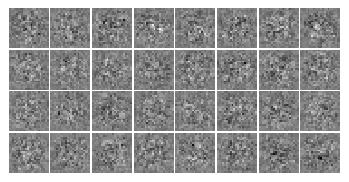

In [74]:
te = (save_gamma_1 != 0).float().permute(1, 0, 2, 3)
te = te.contiguous().view(128, -1).sum(dim=1)
val_sorted, idx_sorted = torch.sort(te, descending=True)

nb_dico_to_plot = 16
np.random.seed(6)
save_fig = False

dico = Net.layers[0].dico
selected_dico = np.random.choice(
    np.arange(dico.size()[0]), nb_dico_to_plot, replace=False)
dico = dico[selected_dico, :, :, :]

grid_param = {'padding': 1, 'normalize': True,
              'pad_value': 1,  'nrow': 8, 'scale_each': False}
to_show = show(make_grid(dico.clone().cpu(), **grid_param))
to_show.show()

if save_fig:
    save_image(make_grid(dico.clone().cpu(), **grid_param),
               path_saving + '/Fig2/Fig2b.png')

dico = Net.layers[0].backward(Net.layers[1].dico)
dico = dico[idx_sorted]
nb_dico_to_plot = 32
subsamp = torch.arange(0, 128, 4)

grid_param = {'padding': 1, 'normalize': True,
              'pad_value': 1,  'nrow': 8, 'scale_each': False}
to_show = show(make_grid(dico[subsamp].clone().cpu(), **grid_param))
to_show.show()

if save_fig:
    save_image(make_grid(dico[subsamp].clone().cpu(),
               **grid_param), path_saving + '/Fig2/Fig2d.png')
